# IBM Applied Data Science Capstone Project: 

# Analyzing and Clustering the districts of Vienna

*Author: Daniel Schnelldorfer*

*March, 2021*

In [1]:
#@hidden cell
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.guim.co.uk/img/media/44907381ba02489d60c01ed449fbbef4f82c9bd4/0_579_8688_5213/master/8688.jpg?width=1200&height=900&quality=85&auto=format&fit=crop&s=b09f64b5e34ef71053ad662a0e28a31a",width =1000, height=1000)

## 1. Introduction:

A successful Italian restaurant chain with many locations spread all over Europe, and a stable financial equipment wants to use the current lockdown in Austria to expand their business. Therefore, they plan to open new restaurants in the biggest Austrian cities. The company is especially interested in the Austrian capital Vienna. What makes Vienna that interesting are the generally high loans, a continuous growth of the population as well as the high cultural diversity of the city and its many foreign cuisines.

So, the company wants to open a new restaurant in Vienna, but doesn't know exactly where. 
The **business question** is: "Which district(s) of Vienna offers the most attractive conditions for opening a new restaurant?". To answer this particular question, the company hires an external data analyst in order to support decision making of the company’s management.

The aim of the analyst's report will be getting an overview of the different districts and their key attributes like population density, competition density, as well as real estate prices. The main part of the analysis will be a clustered map of Vienna’s districts. It is still important to mention, that our restaurants are offering a very basic service and are not in the upper price segment.


## 2. Data  

The **data**, that is used to solve the above business problem, is extracted from the following different **sources**:

1. The table with the different district names, and their corresponding population density is scraped from the following wikipedia page: https://de.wikipedia.org/wiki/Wiener_Gemeindebezirke.

2. A table with the average real estate prices of each district in Vienna will be scraped from the following page: https://de.statista.com/statistik/daten/studie/900881/umfrage/preise-fuer-eigentumswohnungen-in-wien-nach-bezirken/.

3. The geographical coordinates of each district are collected via the python geocoder package.

4. The competition density in each district is determined by the averge number of venues for Italian restaurants in the area. We get those venues by writing the according queries, using therefore the Foursquare API. 






    


## 3. Methodology

###  Import necessary libraries

In [2]:
import numpy as np 

import pandas as pd 

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Folium for map visualizations
!pip install folium
import folium

print('Libraries successfully imported.')

Libraries successfully imported.


### Import district data

At first, we import the data regarding the districts of Vienna and save it into a new dataframe.

In [3]:
#import data
url ='https://de.wikipedia.org/wiki/Wiener_Gemeindebezirke'
df_wiki =pd.read_html(url)

#transform table into csv file
df_wiki[0].to_csv('wikipedia_data.csv')

#read csv file into dataframe
df_vienna_districts =pd.read_csv('wikipedia_data.csv')

#let's get an overview over the dataframe and Viennas's 23 districts
df_vienna_districts

,Unnamed: 0,Nr.,Gemeinde­bezirk,Wappen,Bezirksteile,Eingemeindung,Flächein ha[11],Ein­wohner(2020)[12],Ein­wohnerje km²,Beschäf­tigte(2016)[13]
0,0,01,Innere Stadt,NaN,—,1850: Bezirksfläche außerhalb der Stadtmauer,2869,16.047,NaN,108.679
1,1,02,Leopoldstadt,NaN,Jägerzeile Leopoldstadt Zwischenbrücken,"1850 inkl. Brigittenau, seit 1900 20. Bezirk m...",1.9242,105.848,NaN,66.945
2,2,03,Landstraße,NaN,Landstraße Erdberg Weißgerberviertel,1850; seit 1938 mit Arsenal und Schweizergarte...,7398,91.680,NaN,101.100
3,3,04,Wieden,NaN,Hungelbrunn Schaumburgergrund Wieden,"1850 (bis 1861 inkl. Margareten, bis 1874 inkl...",1775,33.212,NaN,28.439
4,4,05,Margareten,NaN,Hundsturm Laurenzergrund Margareten Matzleinsd...,"1850 als Teil Wiedens, 1861 Bezirk (bis 1874 i...",2012,55.123,NaN,20.567
5,5,06,Mariahilf,NaN,Gumpendorf Laimgrube Magdalenengrund Mariahilf...,1850 (bis 1861 als 5. Bezirk geführt),1455,31.651,NaN,28.676
6,6,07,Neubau,NaN,Altlerchenfeld Neubau Sankt Ulrich Schottenfel...,1850 (bis 1861 als 6. Bezirk geführt),1608,31.961,NaN,33.592
7,7,08,Josefstadt,NaN,Alservorstadt Altlerchenfeld Breitenfeld Josef...,1850 (bis 1861 als 7. Bezirk geführt); seit 18...,1090,25.021,NaN,15.762
8,8,09,Alsergrund,NaN,Alservorstadt Althangrund Himmelpfortgrund Lic...,1850 (bis 1861 als 8. Bezirk geführt); bis 186...,2967,41.884,NaN,49.847
9,9,10,Favoriten,NaN,Favoriten Inzersdorf-Stadt Oberlaa Rothneusied...,"1850: nördlicher Teil im 4., ab 1861 auch 5. B...",3.1828,207.193,NaN,76.051


### Clean and wrangle the data

In [4]:
#We drop the columns, that aren't necessary for further analysis

df_vienna_districts.drop('Unnamed: 0',inplace=True, axis=1)
df_vienna_districts.drop('Bezirksteile',inplace=True, axis=1)
df_vienna_districts.drop('Wappen',inplace=True, axis=1)
df_vienna_districts.drop('Eingemeindung',inplace=True, axis=1)
df_vienna_districts.head()

,Nr.,Gemeinde­bezirk,Flächein ha[11],Ein­wohner(2020)[12],Ein­wohnerje km²,Beschäf­tigte(2016)[13]
0,01,Innere Stadt,2869,16.047,NaN,108.679
1,02,Leopoldstadt,1.9242,105.848,NaN,66.945
2,03,Landstraße,7398,91.680,NaN,101.100
3,04,Wieden,1775,33.212,NaN,28.439
4,05,Margareten,2012,55.123,NaN,20.567


In [5]:
#We also don't need the column "Beschäftigte(2016)[13]" and "Einwohnerje km²", that's why we drop it,too
df_vienna_districts.drop(df_vienna_districts.columns[-1],inplace=True, axis=1)
df_vienna_districts.drop(df_vienna_districts.columns[-1],inplace=True, axis=1)

#let'S have another quick look on our data
df_vienna_districts.head()

,Nr.,Gemeinde­bezirk,Flächein ha[11],Ein­wohner(2020)[12]
0,01,Innere Stadt,2869,16.047
1,02,Leopoldstadt,1.9242,105.848
2,03,Landstraße,7398,91.680
3,04,Wieden,1775,33.212
4,05,Margareten,2012,55.123


In [6]:
#change column names into english
column_names= ['Nr.','District','AreaInHectares','Population']
df_vienna_districts.columns=column_names
df_vienna_districts.head()

,Nr.,District,AreaInHectares,Population
0,01,Innere Stadt,2869,16.047
1,02,Leopoldstadt,1.9242,105.848
2,03,Landstraße,7398,91.680
3,04,Wieden,1775,33.212
4,05,Margareten,2012,55.123


In [7]:
#we have to drop the last two rows, because they don't include any necessary information about the districts
df_vienna_districts.drop(df_vienna_districts.tail(2).index,inplace=True)

#check the dataframe
df_vienna_districts

,Nr.,District,AreaInHectares,Population
0,01,Innere Stadt,2869,16.047
1,02,Leopoldstadt,1.9242,105.848
2,03,Landstraße,7398,91.680
3,04,Wieden,1775,33.212
4,05,Margareten,2012,55.123
5,06,Mariahilf,1455,31.651
6,07,Neubau,1608,31.961
7,08,Josefstadt,1090,25.021
8,09,Alsergrund,2967,41.884
9,10,Favoriten,3.1828,207.193


Due to the fact, that the column with the population per km² contained NaN values, we have to calculate the values manually in the next steps.
Therefore we have to clean the numbers of the two columns first. That means we have to substitute '.' with ' ' and correct the decimal points, where it was imported uncorrectly from the wikipedia table.

In [8]:
#get an overview of the datatypes (necessary for further processing)
df_vienna_districts.dtypes

Nr.               object
District          object
AreaInHectares    object
Population        object
dtype: object

In [9]:
#remove all dots from the numbers
df_vienna_districts['Population'] =df_vienna_districts['Population'].apply(lambda x: x.replace('.',''))
df_vienna_districts['AreaInHectares'] =df_vienna_districts['AreaInHectares'].apply(lambda x: x.replace('.',''))


#insert decimal point before the last digit
df_vienna_districts['AreaInHectares'] =df_vienna_districts['AreaInHectares'].str[:-1] + '.' + df_vienna_districts['AreaInHectares'].str[-1]

In [10]:
#check the data
df_vienna_districts

,Nr.,District,AreaInHectares,Population
0,01,Innere Stadt,286.9,16047
1,02,Leopoldstadt,1924.2,105848
2,03,Landstraße,739.8,91680
3,04,Wieden,177.5,33212
4,05,Margareten,201.2,55123
5,06,Mariahilf,145.5,31651
6,07,Neubau,160.8,31961
7,08,Josefstadt,109.0,25021
8,09,Alsergrund,296.7,41884
9,10,Favoriten,3182.8,207193


So now that our string values have the right format, we can convert them into numeric values for further calculations.

In [11]:
#change datatypes of columns "AreaInHectares" and "Population" from object to numeric for further processing
df_vienna_districts['AreaInHectares']= pd.to_numeric(df_vienna_districts['AreaInHectares'])
df_vienna_districts['Population']= pd.to_numeric(df_vienna_districts['Population'])


In [12]:
#check datatypes
df_vienna_districts.dtypes     

Nr.                object
District           object
AreaInHectares    float64
Population          int64
dtype: object

### Calculate new column 'Residents per km²'

In [13]:
#Change the unit from ha to km²
df_vienna_districts['AreaInHectares'] = df_vienna_districts['AreaInHectares']/100
df_vienna_districts.rename(columns={'AreaInHectares': 'AreaIn km²'}, inplace=True)

#Add and calculate new column called "Residents per km²" manually
df_vienna_districts['Residents per km²'] = df_vienna_districts['Population']/df_vienna_districts['AreaIn km²']

#check the dataframe
df_vienna_districts.head()   

,Nr.,District,AreaIn km²,Population,Residents per km²
0,01,Innere Stadt,2.869,16047,5593.238062
1,02,Leopoldstadt,19.242,105848,5500.883484
2,03,Landstraße,7.398,91680,12392.538524
3,04,Wieden,1.775,33212,18710.985915
4,05,Margareten,2.012,55123,27397.117296


The values of "Residents per km²" look correct so far. In the next steps we want to convert them to integers. Additionally we drop the two columns "Population" and "AreaIn km²", because we don't need them anymore.

In [14]:
#convert float values in "Residents per km²" to integer
df_vienna_districts['Residents per km²']=df_vienna_districts['Residents per km²'].astype(int)

#drop columns
df_vienna_districts.drop('Population',inplace=True, axis=1)
df_vienna_districts.drop('AreaIn km²',inplace=True, axis=1)

#check dataframe
df_vienna_districts.head()

,Nr.,District,Residents per km²
0,01,Innere Stadt,5593
1,02,Leopoldstadt,5500
2,03,Landstraße,12392
3,04,Wieden,18710
4,05,Margareten,27397


### Calculate the Postal Codes for each district 

For the usage of the Foursquare location data, we need to get the postal code for each district. There was no postal code in the table of wikipedia, but we can easily create it manually, using the districts number. That's a great advantage of Vienna here, so that we don't have to extract it from another online source.

In [15]:
#compute Vienna's postal codes manually and rename the column
df_vienna_districts.rename(columns={'Nr.': 'PostalCodes'}, inplace=True)
df_vienna_districts['PostalCodes'] =df_vienna_districts['PostalCodes'].apply(lambda x: '1'+ x +'0')

In [16]:
#check the dataframe
df_vienna_districts.head()

,PostalCodes,District,Residents per km²
0,1010,Innere Stadt,5593
1,1020,Leopoldstadt,5500
2,1030,Landstraße,12392
3,1040,Wieden,18710
4,1050,Margareten,27397


### Real estate data import and cleaning

Due to technical issues with the website of "Statista", the real estate data is imported manually in a list. The private source, that was accessed via my university's VPN didn't enable web scraping. But through the size of the list, this is actually not really a big problem.

In [17]:
#import data
districts_list= ['Innere Stadt','Josefstadt','Wieden','Döbling','Währing','Landstraße','Mariahilf','Alsergrund','Neubau','Leopoldstadt','Hietzing','Hernals','Penzing','Margareten','Ottakring','Donaustadt','Rudolfsheim-Fünfhaus','Floridsdorf','Liesing','Favoriten','Meidling','Brigittenau','Simmering']
prices_list=['17354','9139','8154','7853','7513','7416','7363','7114','7054','6576','6420','6342','5982','5846','5647','5358','5296','5082','5052','5012','4797','4754','4633']

#merge the two lists
lists_merged= list(zip(districts_list, prices_list))

#create the new dataframe
df_vienna_realestate_prices = pd.DataFrame(data=lists_merged, columns=['District','Price m²'])

#check dataframe
df_vienna_realestate_prices

,District,Price m²
0,Innere Stadt,17354
1,Josefstadt,9139
2,Wieden,8154
3,Döbling,7853
4,Währing,7513
5,Landstraße,7416
6,Mariahilf,7363
7,Alsergrund,7114
8,Neubau,7054
9,Leopoldstadt,6576


### Merging all dataframes


In [18]:
#merge the two dataframes with district and real estate information
df_vienna =pd.merge(df_vienna_realestate_prices, df_vienna_districts, on='District')
df_vienna

,District,Price m²,PostalCodes,Residents per km²
0,Innere Stadt,17354,1010,5593
1,Josefstadt,9139,1080,22955
2,Wieden,8154,1040,18710
3,Döbling,7853,1190,2962
4,Währing,7513,1180,8113
5,Landstraße,7416,1030,12392
6,Mariahilf,7363,1060,21753
7,Alsergrund,7114,1090,14116
8,Neubau,7054,1070,19876
9,Leopoldstadt,6576,1020,5500



### Get geographical data

We get the longitude and latitude values of Vienna, using the GeoCoder package.

In [19]:
#use geocoder for getting longitude and latitude values of the city
address = 'Vienna, AT'
geolocator = Nominatim(user_agent="vienna")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#check the coordinates
print('The geograpical coordinates of Vienna are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Vienna are 48.2083537, 16.3725042.


We add the longitude and latitude coordinates to each district, using the corresponding postal code. The python GeoCoder package helps us here again.
The values will be stored in two new columns in the dataframe.

In [20]:
#write function for getting longitude and latitude values
def get_geocoder(postal_code_from_dataframe):
    lat_long_coordinates = None
    
    
 #loop until you get the coordinates 
    while(lat_long_coordinates is None):
        g = geolocator.geocode('{}, Vienna, AT'.format(df_vienna['PostalCodes'][i]))
        latitude = g.latitude
        longitude = g.longitude
        return latitude, longitude 
    
#create empty columns 
df_vienna['Latitude']= None
df_vienna['Longitude']=None


In [21]:
#apply fuction on every row of our dataframe        
for i in range(0,len(df_vienna)):
    
    df_vienna['Latitude'][i],df_vienna['Longitude'][i]=get_geocoder(df_vienna.iloc[i]['PostalCodes'])

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
#check the dataframe
df_vienna

,District,Price m²,PostalCodes,Residents per km²,Latitude,Longitude
0,Innere Stadt,17354,1010,5593,48.2088,16.3707
1,Josefstadt,9139,1080,22955,48.2078,16.3525
2,Wieden,8154,1040,18710,48.1928,16.3692
3,Döbling,7853,1190,2962,48.2494,16.3384
4,Währing,7513,1180,8113,48.2312,16.3286
5,Landstraße,7416,1030,12392,48.1988,16.3932
6,Mariahilf,7363,1060,21753,48.1953,16.3507
7,Alsergrund,7114,1090,14116,48.2299,16.3511
8,Neubau,7054,1070,19876,48.1973,16.3427
9,Leopoldstadt,6576,1020,5500,48.2155,16.3805


### Get venue data

Now we want to use the Foursquare API, to get relevant venue data, in our case: Italian Restaurants.

In [23]:
#@hidden_cell
#define foursquare credentials and version
CLIENT_ID = 'AREIQIIGV4A2QB1UTJSWFHXS12TAHSDQNTZ2PP2W2MZC5Y41'
CLIENT_SECRET ='TDA2BW5JHNS2H5Y4KW0NZI2VNZQ0FHLM03ZL1OLZUQ4LCBTI'
VERSION = '20180605'
search_term = 'Italian Restaurant'
LIMIT=600

print('Settings done for API.')

Settings done for API.


In [24]:
#write fuction in order to get venues for all districts of Vienna 
#authors of this particular function: Alex Aklson & Polong Lin

def getVenueData(names, latitudes, longitudes, radius=1200): 
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create request URL for Foursquare API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            search_term,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only the relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

        #and store the information from the JSON files in a dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
#apply function and get the venue data for each district
df_vienna_venues = getVenueData(names=df_vienna['District'],latitudes=df_vienna['Latitude'],longitudes=df_vienna['Longitude'])

Innere Stadt
Josefstadt
Wieden
Döbling
Währing
Landstraße
Mariahilf
Alsergrund
Neubau
Leopoldstadt
Hietzing
Hernals
Penzing
Margareten
Ottakring
Donaustadt
Rudolfsheim-Fünfhaus
Floridsdorf
Liesing
Favoriten
Meidling
Brigittenau
Simmering


In [26]:
#check the number of Italian restaurants
print('There are {} Italian Restaurants in Vienna.'.format(df_vienna_venues.shape[0]))

#check dataframe
df_vienna_venues.head()

There are 362 Italian Restaurants in Vienna.


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Innere Stadt,48.20875,16.370735,Da Capo,48.207842,16.376277,Italian Restaurant
1,Innere Stadt,48.20875,16.370735,Fabios Restaurant Bar,48.210035,16.369763,Italian Restaurant
2,Innere Stadt,48.20875,16.370735,Cantinetta Antinori,48.208949,16.371954,Italian Restaurant
3,Innere Stadt,48.20875,16.370735,Al Borgo,48.206686,16.377436,Italian Restaurant
4,Innere Stadt,48.20875,16.370735,Ristorante Firenze,48.207867,16.372302,Italian Restaurant


In the next steps, we want to get the total number of Italian restaurants for each district and add it to our df_vienna.

In [27]:
#we group the venues by district and save it into a new dataframe
df_vienna_venues_grouped = df_vienna_venues.groupby(['District']).count()['Venue']

In [28]:
#check the dataframe
df_vienna_venues_grouped

District
Alsergrund               9
Brigittenau              3
Döbling                  4
Favoriten                1
Floridsdorf              2
Hernals                  2
Hietzing                 6
Innere Stadt            71
Josefstadt              49
Landstraße              19
Leopoldstadt            56
Liesing                  2
Margareten              17
Mariahilf               40
Meidling                 4
Neubau                  27
Ottakring                5
Penzing                  4
Rudolfsheim-Fünfhaus     9
Wieden                  28
Währing                  4
Name: Venue, dtype: int64

In [29]:
#check, how many districts are missing
df_vienna_venues_grouped.shape

(21,)

As we can see, the two districts "Donaustadt" and "Simmering" have been removed of the dataframe, because they contained not a single restaurant in the given radius. But that's so far not a problem. Later, when we merge the data in another dataframe, the rows will be there again, containing zero as a value.

In [30]:
#merge the new dataframe to df_vienna
df_vienna =df_vienna.merge(df_vienna_venues_grouped, on='District',how='left').fillna(0)

#rename 'Venue' to 'Italian Restaurants'
df_vienna.rename(columns={'Venue': 'Italian Restaurants'}, inplace=True)

#check the datframe
df_vienna

,District,Price m²,PostalCodes,Residents per km²,Latitude,Longitude,Italian Restaurants
0,Innere Stadt,17354,1010,5593,48.208750,16.370735,71.0
1,Josefstadt,9139,1080,22955,48.207793,16.352502,49.0
2,Wieden,8154,1040,18710,48.192806,16.369190,28.0
3,Döbling,7853,1190,2962,48.249367,16.338429,4.0
4,Währing,7513,1180,8113,48.231200,16.328649,4.0
5,Landstraße,7416,1030,12392,48.198756,16.393209,19.0
6,Mariahilf,7363,1060,21753,48.195262,16.350736,40.0
7,Alsergrund,7114,1090,14116,48.229912,16.351149,9.0
8,Neubau,7054,1070,19876,48.197257,16.342721,27.0
9,Leopoldstadt,6576,1020,5500,48.215485,16.380536,56.0


Looks fine so far. Now we have all data cleaned, that we need for our analysis.

## 3.2 Exploratory data analysis

Now we can start analyzing our dataset and visualize the results in this section.

In [31]:
#create map for Vienna

vienna_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers of the Districts to the map
for lat, lng, district in zip(df_vienna['Latitude'], df_vienna['Longitude'], df_vienna['District']):
    label = ' {}'.format( district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vienna_map)  

# add markers of the Italian restaurants to the map
for lat, lng, venue in zip(df_vienna_venues['Venue Latitude'], df_vienna_venues['Venue Longitude'], df_vienna_venues['Venue']):
    label = ' {}'.format( venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='lightblue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vienna_map)  
    
vienna_map  

Note: The districts have red markers, and the Italian restaurants are colored blue.

Now we know how the city of vienna looks like, and where the different districts in the city are located, as well as the most Italian Restaurants.

In [32]:
# Import Matplotlib and associated plotting modules
import matplotlib as mp
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

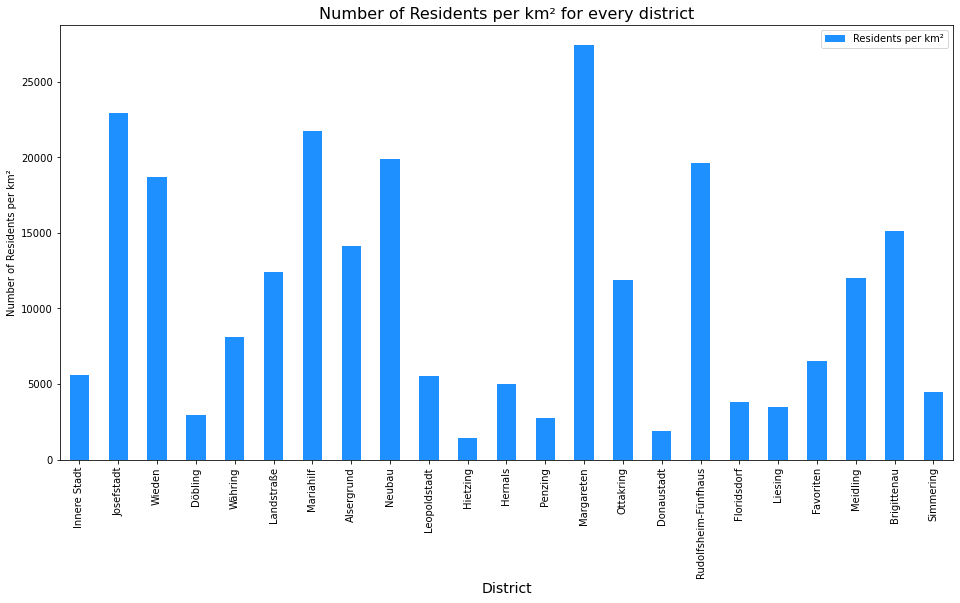

In [33]:
#Visualize distribution of population for all districts of Vienna

df_vienna.plot(kind='bar', figsize=(16,8), x='District', y='Residents per km²',color='dodgerblue')
plt.xlabel('District', size=14)
plt.ylabel('Number of Residents per km²')
plt.title('Number of Residents per km² for every district', size=16)
plt.show()

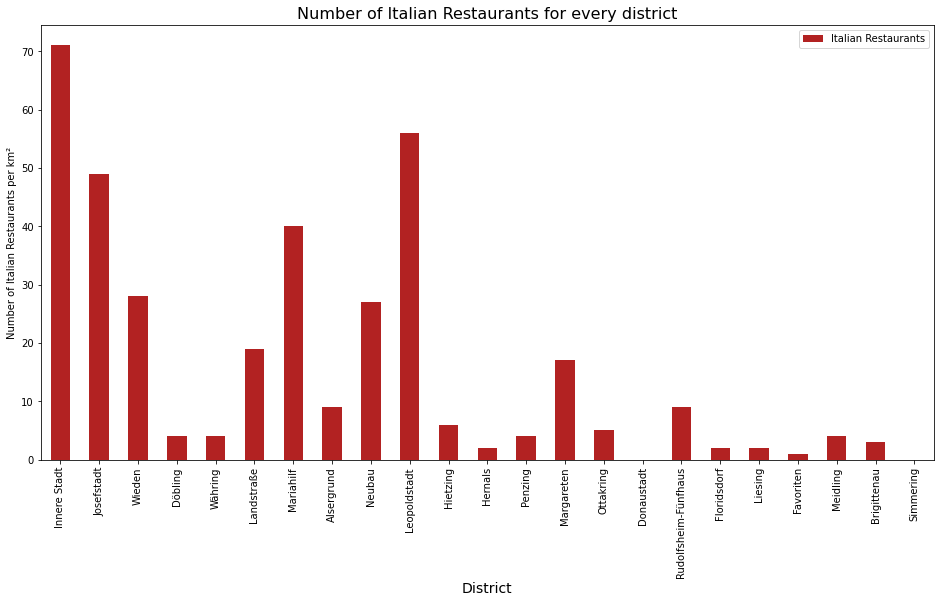

In [34]:
#Visualize distribution of Italian restaurants for all districts of Vienna

df_vienna.plot(kind='bar', figsize=(16,8), x='District', y='Italian Restaurants',color='firebrick')
plt.xlabel('District', size=14)
plt.ylabel('Number of Italian Restaurants per km²')
plt.title('Number of Italian Restaurants for every district', size=16)
plt.show()

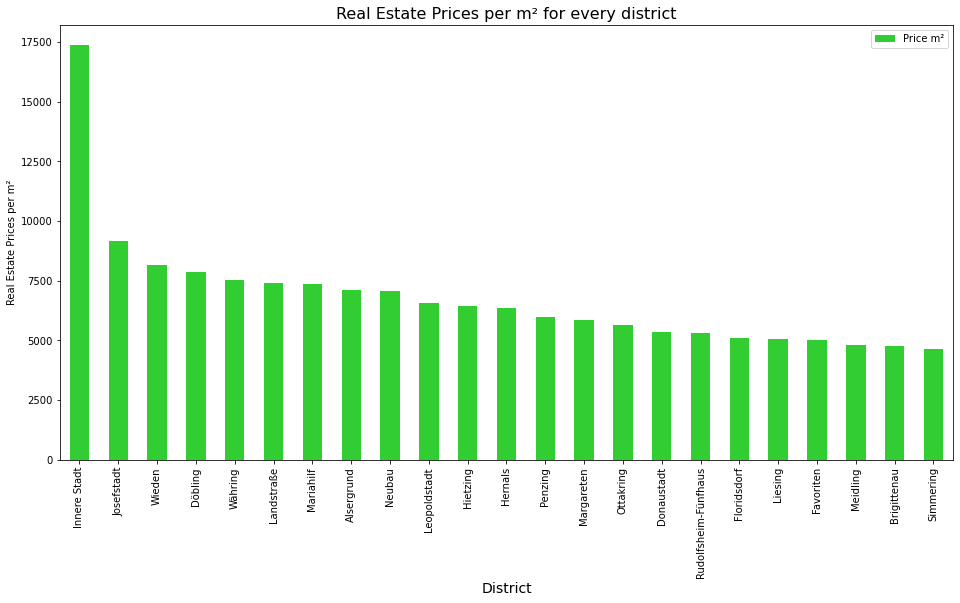

In [35]:
#Transform real estate prices to numeric
df_vienna['Price m²']= pd.to_numeric(df_vienna['Price m²'])

#Visualize distribution of RealEstate Prices for all districts of Vienna

df_vienna.plot(kind='bar', figsize=(16,8), x='District', y='Price m²',color='limegreen')
plt.xlabel('District', size=14)
plt.ylabel('Real Estate Prices per m²')
plt.title('Real Estate Prices per m² for every district', size=16)
plt.show()

## 3.3 Clustering 

To simplify decision making in our case, we want to segment Vienna's districts into three clusters.
In our case, the most relevant elements, to be considered in the clustering algorithm are the number of Italian restaurants.

In [36]:
# import k-means algorithm
from sklearn.cluster import KMeans

In [37]:
#create new dataframe for clustering
df_vienna_for_clustering = df_vienna.copy()

#remove unnecessary columns 
df_vienna_for_clustering.drop(['District','Latitude','Longitude','PostalCodes','Price m²','Residents per km²'],axis=1,inplace=True)

#check dataframe
df_vienna_for_clustering.head()

,Italian Restaurants
0,71.0
1,49.0
2,28.0
3,4.0
4,4.0


In [38]:
# set number of clusters
kclusters = 3


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_vienna_for_clustering)

#assign the cluster label to each district of the original dataframe
df_vienna.insert(0,'Cluster Labels', kmeans.labels_ )

#check the labels
df_vienna.head()

,Cluster Labels,District,Price m²,PostalCodes,Residents per km²,Latitude,Longitude,Italian Restaurants
0,2,Innere Stadt,17354,1010,5593,48.208750,16.370735,71.0
1,2,Josefstadt,9139,1080,22955,48.207793,16.352502,49.0
2,1,Wieden,8154,1040,18710,48.192806,16.369190,28.0
3,0,Döbling,7853,1190,2962,48.249367,16.338429,4.0
4,0,Währing,7513,1180,8113,48.231200,16.328649,4.0


In [39]:
#visualize the different clusters of Vienna's districts
vienna_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# set different colors for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_vienna['Latitude'], df_vienna['Longitude'], df_vienna['District'], df_vienna['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(vienna_clusters_map)
    
vienna_clusters_map 

For a better overview, we want to show again the different characteristics for each cluster in the above map.

#### Red Cluster: 

In [40]:
df_vienna.loc[df_vienna['Cluster Labels'] == 0]

,Cluster Labels,District,Price m²,PostalCodes,Residents per km²,Latitude,Longitude,Italian Restaurants
3,0,Döbling,7853,1190,2962,48.249367,16.338429,4.0
4,0,Währing,7513,1180,8113,48.231200,16.328649,4.0
7,0,Alsergrund,7114,1090,14116,48.229912,16.351149,9.0
10,0,Hietzing,6420,1130,1432,48.175907,16.276513,6.0
11,0,Hernals,6342,1170,5006,48.227044,16.309270,2.0
12,0,Penzing,5982,1140,2773,48.207082,16.260296,4.0
14,0,Ottakring,5647,1160,11889,48.212891,16.313489,5.0
15,0,Donaustadt,5358,1220,1908,48.230605,16.479091,0.0
16,0,Rudolfsheim-Fünfhaus,5296,1150,19605,48.194818,16.327152,9.0
17,0,Floridsdorf,5082,1210,3779,48.267900,16.405105,2.0


#### Purple Cluster:

In [41]:
df_vienna.loc[df_vienna['Cluster Labels'] == 1]

,Cluster Labels,District,Price m²,PostalCodes,Residents per km²,Latitude,Longitude,Italian Restaurants
2,1,Wieden,8154,1040,18710,48.192806,16.369190,28.0
5,1,Landstraße,7416,1030,12392,48.198756,16.393209,19.0
6,1,Mariahilf,7363,1060,21753,48.195262,16.350736,40.0
8,1,Neubau,7054,1070,19876,48.197257,16.342721,27.0
13,1,Margareten,5846,1050,27397,48.186531,16.364161,17.0


#### Green Cluster:

In [42]:
df_vienna.loc[df_vienna['Cluster Labels'] == 2]

,Cluster Labels,District,Price m²,PostalCodes,Residents per km²,Latitude,Longitude,Italian Restaurants
0,2,Innere Stadt,17354,1010,5593,48.208750,16.370735,71.0
1,2,Josefstadt,9139,1080,22955,48.207793,16.352502,49.0
9,2,Leopoldstadt,6576,1020,5500,48.215485,16.380536,56.0


## 4. Results

Our clustering algorithm has segmented Vienna's districts into three different clusters by the number of Italian Restaurants in each district:
* **red:** 0-9 Italian Restaurants
* **purple:** 17-40 Italian Restaurants
* **green:** 49-71 Italian Restaurants

The results show, that the ideal places to open a new restaurant are in the districts of the red and the purple markers. In those areas the demand for new restaurants is by far the highest. The green areas are too competitive in our case. The real estate prices, which have to be considered as well are especially high in the centered districts, but the difference between the red and purple districts are not really high. The population density is the highest in most of the purple markers, whereas the lowest population density can be found in 'Innere Stadt' as well as in the outskirts. 

## 5. Discussion


**Data:**
The data regarding district information, real estate prices, as well as the geographical data, that has been used in this lab is of sufficient quality. On the other hand the venue data for the number of Italian Restaurants was not 100% accurate, but still adequate to get a clue about the distribution of Italian Restaurants over Vienna's districts.

**Methodology:**
The applied explorative analysis has delivered quite good insights in the dataset. The visualizations were necessary and easy to interpret. Although the clustering algorithm applied on this comparatively small dataset was quite an overkill, the results are still supporting our analysis and providing a good overview of the different districts.
    
**Quality of results:**
Our results can provide helpful support in decision making for the company's management. But it's still important to note, that our dataset is not including all necessary information, which the management needs to make a 100% evidence-based decision. That would require a much higher quantity and quality of data. For example, we should not only cover the information for each district, but also for each neighborhood, perhaps even each single block has to be considered as a single unit. Additionally many other key aspects, such as individual financing plans and real estate prices for different locations, number of tourists, traffic density, income of the local residents, etc. have to be considered.

## 6. Conclusion

As we have seen in our results section, there are several districts in the city of Vienna, that seem very attractive for a new Italian restaurant. In those districts, we don't only have a very small number of existing Italian Restaurants, which means less competition. A high population density in those districts means a potentially unsatisfied demand, which offers great opportunity for a new restaurant.

In conclusion, the most attractive districts in Vienna to be considered are Rudolfsheim-Fünfhaus, Margareten, Meidling, Brigittenau and Währing. Those offer a high population density in combination with a moderate number of existing Italian restaurants.	 